Script for creating and training the LSTM network models used to generate classical music.

Matilda Wikström

Jesper Larsson

Links to good stuff!

https://github.com/craffel/pretty-midi

https://towardsdatascience.com/generate-piano-instrumental-music-by-using-deep-learning-80ac35cdbd2e





In [2]:
#Imports
import torch
import pretty_midi
import numpy as np
import unicodedata
import re
import numpy as np
from random import shuffle, seed
import os
import io
import time
from tqdm import tnrange, tqdm_notebook, tqdm
# "Our code"
import preprocessing as pp
#import generatemidi as gm # Broken file, fix
import tokenizer as token
import generatemidi as gen

In [ ]:
# Using pretty_midi example
fs=30
dict_note = {}
midi_pretty_format = pretty_midi.PrettyMIDI('test.midi')
piano_midi = midi_pretty_format.instruments[0] # Get the piano channels
piano_roll = piano_midi.get_piano_roll(fs=fs)
dict_note[0] = piano_roll

print(len(piano_roll[0]))

In [3]:
#Download the required data create folder structure
#Make sure we are in the correct folder

assert (os.path.basename(os.getcwd())=='LSTM-MusicGenerator'), "Wrong working dir"

#Download the MAESTRO Dataset
if not os.path.isfile('./maestro-v1.0.0-midi.zip'):
    !wget https://storage.googleapis.com/magentadata/datasets/maestro/v1.0.0/maestro-v1.0.0-midi.zip

#Check if we have extracted the files
if not os.path.isdir('./maestro-v1.0.0-midi') and not os.path.isfile('./maestro-v1.0.0/LICENSE'):
    !unzip maestro-v1.0.0-midi.zip


/bin/sh: 1: wget: not found


In [3]:
# Preprocessing
nbr_of_songs = 10 #100
list_all_midi = pp.get_list_midi() # 
sampled_200_midi = list_all_midi[0:nbr_of_songs]
batch = 1
start_index = 0
note_tokenizer = token.NoteTokenizer()
import pretty_midi

for i in tqdm_notebook(range(len(sampled_200_midi))):
    dict_time_notes = token.generate_dict_time_notes(sampled_200_midi, batch_song=1, start_index=i, use_tqdm=False, fs=5)
    full_notes = token.process_notes_in_song(dict_time_notes)
    for note in full_notes:
        note_tokenizer.partial_fit(list(note.values()))
note_tokenizer.add_new_note('e') # Add empty notes



In [4]:
# ---- define model
import torch.nn as nn
import torch.nn.functional as F
   
input_size = 50
hidden_size = 200
num_layers = 1
is_bidirectional = True
dropout_rate = 0
batch_size = 1 #96 ### Should be 2085

seq_len = 50
unique_notes = note_tokenizer.unique_word #Used in our output layer to map



if is_bidirectional:
    num_directions = 2
else:
    num_directions = 1


class our_LSTM(torch.nn.Module):
    def __init__(self, h0, c0):
        super().__init__()
        self.hn = h0
        self.cn = c0
        
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, bidirectional=is_bidirectional)
        self.fc = torch.nn.Linear(num_directions * hidden_size, unique_notes)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, inp, use_softmax = False):
        out, (self.hn, self.cn) = self.lstm(inp, (self.hn, self.cn))
        out = self.fc(out)
        if use_softmax:
            out = self.softmax(out)
        out = out.permute(0,2,1)
        out = out.view(-1,unique_notes)
        
        return out, self.hn, self.cn
    


<IPython.core.display.Javascript object>


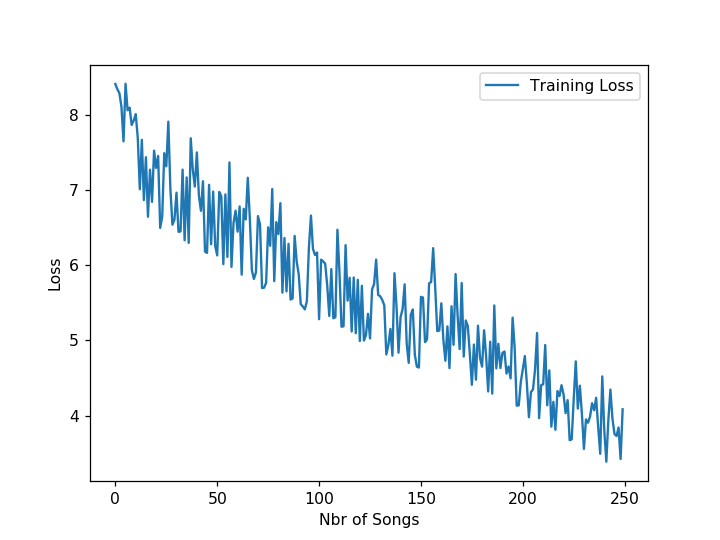

In [8]:
from torch import optim
import matplotlib.pyplot as plt

# ---- variables
seq_len = 50 
EPOCHS = 10
BATCH_SONG = 1 #16
BATCH_NNET_SIZE = 128 
TOTAL_SONGS = len(sampled_200_midi)
FRAME_PER_SECOND = 5
DATE = 20191022

# ---- initialize model, states, loss fcn, optimizer 
hn = torch.zeros(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
cn = torch.zeros(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
model = our_LSTM(hn,cn)

# -- load trained model
model.load_state_dict(torch.load('lstm_20191022_1layer_200hidden_ep15_3'))
START_EPOCH = 15

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

# ---- live plotting
%matplotlib notebook 
fig, axes = plt.subplots(1,1)
plt.ion()
fig.show()
fig.canvas.draw()
loss_vec = []
loss_vec = np.load('loss_20191022_1layer_200hiddenep15_3.npy', allow_pickle=True).tolist()




# ---- training loop
for epoch in tqdm_notebook(range(START_EPOCH,START_EPOCH+EPOCHS), desc='epoch'):
    batch_song = BATCH_SONG
    frame_per_second = FRAME_PER_SECOND
    shuffle(sampled_200_midi)
        
    for i in tqdm_notebook(range(0,len(sampled_200_midi),BATCH_SONG), desc=f'completed songs in epoch {epoch+1}'):
        
        # -- prepare data
        inputs_nnet_large, outputs_nnet_large = token.generate_batch_song(
                sampled_200_midi, batch_song, start_index=i, fs=frame_per_second, 
                seq_len=seq_len, use_tqdm=False)
        trans_in = note_tokenizer.transform(inputs_nnet_large)
        trans_out = note_tokenizer.transform(outputs_nnet_large)
        trans_out = trans_out - 1
        
        # -- reset hidden states every song
        model.hn.detach_()
        model.cn.detach_()
        
        # -- train on 1 song 
        counter = 0
        for j in range(0,len(trans_in)-BATCH_NNET_SIZE,BATCH_NNET_SIZE):
            counter += 1 
            input_tensor = trans_in[j:j+BATCH_NNET_SIZE]
            target_tensor = trans_out[j:j+BATCH_NNET_SIZE]

            input_tensor = torch.tensor(input_tensor,dtype=torch.float32)
            input_tensor = input_tensor[None,:,:] # Should be (seq_len, batch, input_size)
            input_tensor = input_tensor.permute(1,0,2)
            target_tensor = torch.tensor(target_tensor,dtype=torch.long).view(-1)
            pred, hn, cn = model(input_tensor)
            loss = loss_fn(pred,target_tensor)
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
        
        # -- plot loss after every song
        loss_vec.append(loss)
        axes.clear()
        axes.plot(loss_vec)
        axes.set_xlabel('Nbr of Songs')
        axes.set_ylabel('Loss')
        plt.legend(["Training Loss"])
        fig.canvas.draw()
    
    # -- save model and loss vector
    torch.save(model.state_dict(), f'lstm_{DATE}_{num_layers}layer_{hidden_size}hidden_ep{epoch+1}_3')
    np.save(f'loss_{DATE}_{num_layers}layer_{hidden_size}hiddenep{epoch+1}_3', np.array(loss_vec))
    
    # -- reset hidden states every song
    model.hn.detach_()
    model.cn.detach_()





In [6]:
# ---- save model and loss vector
torch.save(model.state_dict(), f'lstm_{DATE}_{num_layers}layer_{hidden_size}hidden_ep{15}_3')
np.save(f'loss_{DATE}_{num_layers}layer_{hidden_size}hiddenep{15}_3', np.array(loss_vec))

In [7]:
# ---- help function for generating mew music and creating MIDI file
def generate_from_random(unique_notes, seq_len=50):
  generate = np.random.randint(0,unique_notes-1,seq_len).tolist()
  return generate
    
def generate_from_one_note(note_tokenizer, new_notes='35'):
  generate = [note_tokenizer.notes_to_index['e'] for i in range(49)]
  generate += [note_tokenizer.notes_to_index[new_notes]]
  return generate

def generate_notes(generate, model, unique_notes, max_generated=1000, seq_len=50):
  for i in tqdm_notebook(range(max_generated), desc='genrt'):
    test_input = np.array([generate])[:,i:i+seq_len]
    test_input = torch.tensor(test_input, dtype=torch.float32)
    test_inputa = test_input[None,:,:]
    
    predicted_note, _, _ = model(test_inputa, use_softmax=True)
    predicted_note = predicted_note.detach().numpy()
    predicted_note[predicted_note<0]=0
    prednote=predicted_note/np.sum(predicted_note)
    
    random_note_pred = np.random.choice(unique_notes, 1, replace=False, p=prednote[0])
    generate.append(random_note_pred[0])
    #generate.append(predicted_note.argmax(dim=1).item())
  return generate


def write_midi_file_from_generated(generate, midi_file_name = "result.mid", start_index=0, fs=8, max_generated=1000):
    generate = np.array(generate)
    generate[generate<1] = 1
    note_string = [note_tokenizer.index_to_notes[ind_note] for ind_note in generate]
    array_piano_roll = np.zeros((128,max_generated+1), dtype=np.int16)
 
    for index, note in enumerate(note_string[start_index:]):
       if note == 'e':
         pass
       else:
         splitted_note = note.split(',')
         for j in splitted_note:
           array_piano_roll[int(j),index] = 1
 
    generate_to_midi = pp.piano_roll_to_pretty_midi(array_piano_roll, fs=fs)
    print("Tempo {}".format(generate_to_midi.estimate_tempo()))
    for note in generate_to_midi.instruments[0].notes:
        note.velocity = 100
    generate_to_midi.write(midi_file_name)


In [8]:
# ---- load saved model
hn = torch.randn(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
cn = torch.randn(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
model = our_LSTM(hn,cn)

model.load_state_dict(torch.load('lstm_20191022_1layer_200hidden_ep15_3'))

<All keys matched successfully>

In [10]:
# ---- generate new music
max_generate = 200
input_len = 10
unique_notes = note_tokenizer.unique_word
print(unique_notes)
seq_len=50
generate = generate_from_random(unique_notes-1, seq_len)
# generate = generate_from_one_note(note_tokenizer, '42')
print(generate)
generate_song = generate_notes(generate, model, unique_notes, max_generate, seq_len)
print(generate_song)
write_midi_file_from_generated(generate_song, "hello.mid", start_index=seq_len-1, fs=4, max_generated = max_generate)

5756
[2893, 3831, 1493, 2514, 1151, 1594, 5238, 1322, 3512, 2068, 364, 3608, 3579, 4121, 964, 4698, 3049, 1308, 3538, 3530, 2455, 4248, 3214, 3528, 5220, 1795, 3282, 2120, 133, 2902, 5446, 1233, 3504, 3396, 561, 3851, 760, 2938, 1341, 5177, 1529, 374, 4018, 3806, 2825, 2753, 4933, 4618, 1010, 1517]



[2893, 3831, 1493, 2514, 1151, 1594, 5238, 1322, 3512, 2068, 364, 3608, 3579, 4121, 964, 4698, 3049, 1308, 3538, 3530, 2455, 4248, 3214, 3528, 5220, 1795, 3282, 2120, 133, 2902, 5446, 1233, 3504, 3396, 561, 3851, 760, 2938, 1341, 5177, 1529, 374, 4018, 3806, 2825, 2753, 4933, 4618, 1010, 1517, 5755, 2127, 223, 127, 1015, 3008, 37, 37, 2331, 2179, 5755, 5755, 4806, 295, 142, 983, 5136, 23, 2637, 1413, 5755, 2346, 5755, 161, 4150, 5755, 344, 2072, 5755, 65, 5755, 140, 0, 5488, 512, 971, 304, 65, 947, 5755, 350, 121, 307, 13, 143, 1620, 5755, 84, 37, 286, 95, 1149, 858, 84, 5755, 771, 1611, 223, 869, 5755, 2707, 5755, 1881, 1209, 227, 778, 5755, 857, 140, 23, 690, 5755, 5755, 1452, 341, 4719, 497, 205, 5755, 127, 120, 386, 126, 340, 497, 2777, 554, 113, 478, 756, 1522, 1026, 2072, 1172, 307, 153, 23, 1976, 399, 157, 1025, 32, 395, 227, 762, 296, 286, 340, 174, 5755, 5755, 157, 5310, 1355, 1401, 262, 708, 143, 140, 5755, 947, 3983, 872, 5623, 5755, 1830, 5755, 1840, 13, 23, 1282, 1976, 38

In [ ]:
############ NOT USED ###################3
max_generate = 300
unique_notes = note_tokenizer.unique_word
seq_len=50
generate = generate_from_one_note(note_tokenizer, '72')
generate = generate_notes(generate, model, unique_notes, max_generate, seq_len)
print(generate)
write_midi_file_from_generated(generate, "one_note.mid", start_index=seq_len-1, fs=8, max_generated = max_generate)

In [ ]:
############ NOT USED ###################3

hn = torch.randn(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
cn = torch.randn(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
model = our_LSTM(hn,cn)

model.load_state_dict(torch.load('lstm_20191029_4eps'))

def generate_from_random(unique_notes, seq_len=50):
  generate = np.random.randint(0,unique_notes-1,seq_len).tolist()
  return generate
    
def generate_from_one_note(note_tokenizer, new_notes='35'):
  generate = [note_tokenizer.notes_to_index['e'] for i in range(49)]
  generate += [note_tokenizer.notes_to_index[new_notes]]
  return generate

def generate_depth(generate, max_generated=1000):
    depth_vector = torch.tensor(generate)
    depth_vector = depth_vector.view(-1,1,50)
    return depth_vector
    for i in range(max_generated):
        ;
        
    

def generate_notes(generate, model, unique_notes, max_generated=1000, seq_len=50):
  for i in tqdm_notebook(range(max_generated), desc='genrt'):
    test_input = np.array([generate])[:,i:i+seq_len]
    test_input = torch.tensor(test_input, dtype=torch.float32)
    test_inputa = test_input[None,:,:]
    
    #print(test_inputa.shape)
    #print(test_inputa)
    predicted_note, _, _ = model(test_inputa, use_softmax=True)
    #random_note_pred = np.random.choice(unique_notes+1, 1, replace=False, p=predicted_note[0])
    #generate.append(random_note_pred[0])
    #print(predicted_note.shape)
    predicted_note = predicted_note.view(len(predicted_note))
    predicted_note = predicted_note.detach().numpy()
    #predicted_note[predicted_note<0] = 0
    #predicted_note = predicted_note/np.sum(predicted_note)
    #print(min(predicted_note))
    #print(predicted_note.shape)
    
    choice = np.random.choice(len(predicted_note),p=predicted_note)
    #generate.append(predicted_note.argmax(dim=1).item())
    generate.append(choice)
  return generate


def write_midi_file_from_generated(generate, midi_file_name = "result.mid", start_index=0, fs=2, max_generated=1000):
 generate = np.array(generate)
 generate[generate<1] = 1
 #generate = generate - 1
 note_string = [note_tokenizer.index_to_notes[ind_note] for ind_note in generate]
 array_piano_roll = np.zeros((128,max_generated+1), dtype=np.int16)
 for index, note in enumerate(note_string[start_index:]):
   if note == 'e':
     pass
   else:
     splitted_note = note.split(',')
     for j in splitted_note:
       array_piano_roll[int(j),index] = 1
 generate_to_midi = pp.piano_roll_to_pretty_midi(array_piano_roll, fs=fs)
 print("Tempo {}".format(generate_to_midi.estimate_tempo()))
 for note in generate_to_midi.instruments[0].notes:
   note.velocity = 100
 generate_to_midi.write(midi_file_name)